### Introduction

I am looking at NBA team data from 2001-02 through this past season (the cutoff is a bit arbitrary, it's related to the availability of some data on [Basketball Reference](https://www.basketball-reference.com)). I am using this data to predict the difference between the actual winning perecentage of teams and their expected winning percentage by [Pythagorean expectation](https://en.wikipedia.org/wiki/Pythagorean_expectation). My hunch is that performance in close games has some explanatory power for this dependent variable, but what exactly characterizes this type of performance -- is it defense, shooting, getting to the free throw line, simply having an extremely efficient superstar?

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

import statsmodels.api as sm
import statsmodels.formula.api as smf

import re

import bbref_scrape

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In particular, I wanted to scrape the [Four Factors](https://www.nbastuffer.com/analytics101/four-factors/), which some have found to correlate well with offensive/defensive success in basketball:
* **Effective Field Goal Pct.**: The percentage of shots made (adjusting for 3 point shots being worth more than 2 point shots
* **Offensive Rebounding Pct.**: The percentage of available offensive rebounds collected
* **Turnover Pct.**: The percentage of plays ending in a turnover
* **Free Throw Attempt Rate**: The free throw attempts per field goal attempts

Some of this data is included in the "Season Summary" pages from [Basketball Reference](https://www.basketball-reference.com). Here's an [example](https://www.basketball-reference.com/leagues/NBA_2018.html) -- there are lots of tables in here summarizing a wide array of stats for each team over the course of a single season.

Below I scrape everything from the 2001-02 through 2017-18 seasons and then do some cleanup of the eventual dataframe. Also calculate the win percentage, Pythag win percentage, and the difference between them:

In [2]:
# scrape from team pages the "Miscellaneous Stats" table
years = np.arange(2002, 2019)
#summ_tbl_strings = ['team-stats-base', 'opponent-stats-base', 'misc_stats', 'team_shooting', 'opponent_shooting']
summ_tbl_strings = ['misc_stats']

df = pd.DataFrame()

for yr in years:
    df2 = pd.DataFrame()
    for string in summ_tbl_strings:
        tmp = bbref_scrape.tbl_scrape_from_bbref_seasonsumm(string, yr)
        df2 = pd.concat([df2, tmp], axis=1)
    df = pd.concat([df, df2])

The data, even the numeric data, are read in as strings, so below I first convert everything as such. Then, I compute the actual winning percentage and the Pythag winning percentage (`PW` and `PL` are the Pythag wins and losses that are included in the scraped table). 

I then compute `diffWP` as the difference between actual and expected (Pythag) winning percentage. If this difference is positive (negative), a team can be said to have overperformed (underperformed).

In [3]:
# convert numerics (which are strings) to numerics
# then calculate WP as Win% (WP)
# then calculate expected Win% (xWP) (i.e., Pythag Win%)
# then the difference and drop teams with fewer than 30 wins (teams that were tanking may not be relevant)
df = df.apply(pd.to_numeric, errors='ignore')
df['WP'] = df['W']/(df['W'] + df['L'])
df['xWP'] = df['PW']/(df['PW'] + df['PL'])
df['diffWP'] = df['WP'] - df['xWP']

Each year a lot of teams are more or less intentionally losing (tanking) which may have some impact on the results. Let's remove those teams from the dataset for now and examine correlations between the features and the response `diffWP`.

In [4]:
dfnotank = df[df['W'] >= 30]

Let's drop some columns corresponding to potential features used to compute `diffWP` such as `W`, `L`, `PW`, `PL`, `WP` and `xWP`, and take a look at correlations between the response `diffWP` and remaining features.

In [5]:
dfnotank.drop(['WP', 'xWP', 'W', 'L', 'PW', 'PL', 'Arena', 'Attend.', 'Attend./G'], axis=1, inplace=True)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


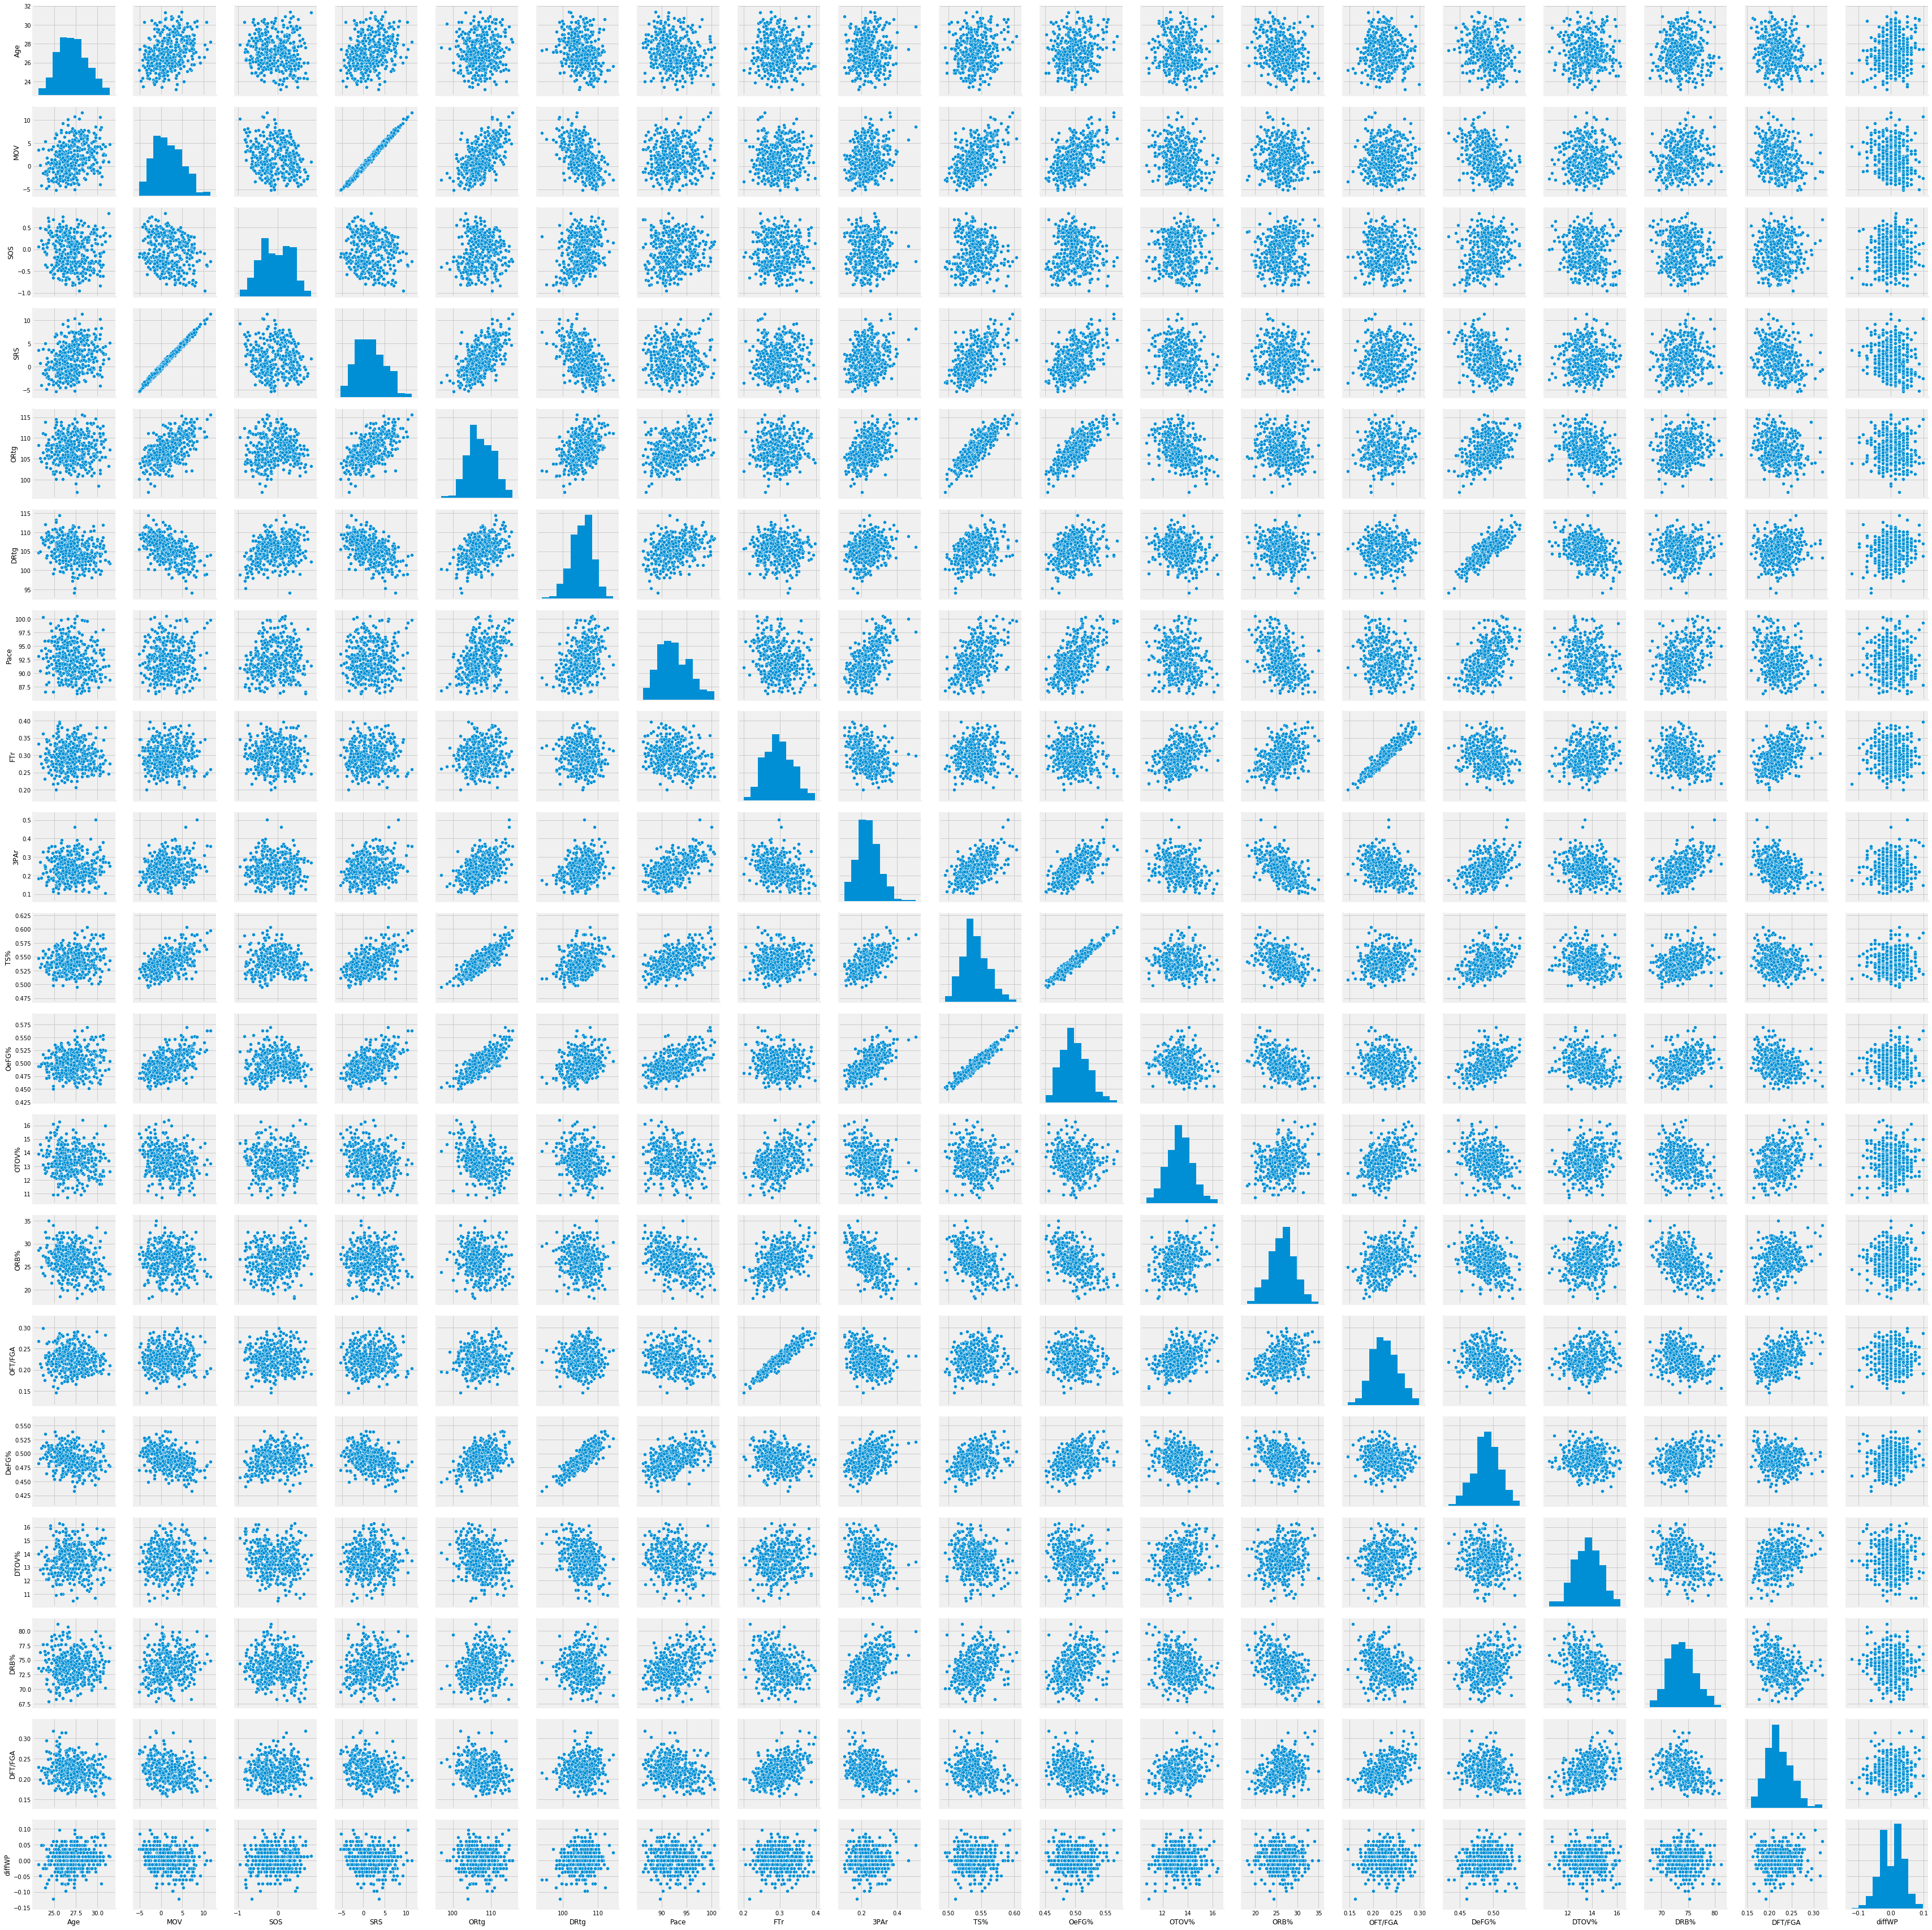

In [6]:
sns.pairplot(dfnotank)

There are few strong correlations (for a linear relationship) between `diffWP` and some of the potential features. There appears to be a fair amount of collinearity between features. This is to be expected, considering (for example) that all of the "four factors" are supposed to be highly correlated with Offensive Rating `ORtg` and Defensive Rating `DRtg`.

Let us run an initial model now even considering the above.

In [7]:
# add an intercept column
dfnotank['Ones'] = np.ones(len(dfnotank))

# add year column to facilitate test-train split
dfnotank['Year'] = [int(re.search('\d+$', teamyr).group(0)) for teamyr in dfnotank.index]

# split into train, test, holdout by years
dftrain = dfnotank[dfnotank['Year'] <= 2012]
dftest = dfnotank[(dfnotank['Year'] > 2012) & (dfnotank['Year'] <= 2017)]
dfholdout = dfnotank[dfnotank['Year'] > 2017]

# training set
Ytrain = dftrain['diffWP']
Xtrain = dftrain.drop(['diffWP', 'Year'], axis = 1)

# test set
Ytest = dftest['diffWP']
Xtest = dftest.drop(['diffWP','Year'], axis = 1)

# holdout set
Yholdout = dfholdout['diffWP']
Xholdout = dfholdout.drop(['diffWP','Year'], axis = 1)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [8]:
lml = sm.OLS(Ytrain,Xtrain)

In [9]:
fit = lml.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 diffWP   R-squared:                       0.166
Model:                            OLS   Adj. R-squared:                  0.103
Method:                 Least Squares   F-statistic:                     2.618
Date:                Wed, 18 Jul 2018   Prob (F-statistic):           0.000506
Time:                        17:33:57   Log-Likelihood:                 521.13
No. Observations:                 256   AIC:                            -1004.
Df Residuals:                     237   BIC:                            -936.9
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Age            0.0041      0.002      2.637      0.009       0.001       0.007
MOV            0.4557      0.397      1.146      0.253      -0.327       1.239
SOS            0.4487      0.395      1.136      0.257      -0.329       1.227
SRS           -0.4414      0.396     -1.116      0.266      -1.221       0.338
ORtg          -0.0242      0.023     -1.036      0.301      -0.070       0.022
DRtg           0.0260      0.022      1.196      0.233      -0.017       0.069
Pace          -0.0005      0.001     -0.429      0.668      -0.003       0.002
FTr            1.7003      0.996      1.707      0.089      -0.262       3.663
3PAr           0.0460      0.080      0.574      0.567      -0.112       0.204
TS%            9.5466      4.749      2.010      0.046       0.191      18.902
OeFG%         -7.1243      4.099     -1.738      0.084     -15.200       0.951
OTOV%         -0.0121      0.017     -0.714      0.476      -0.045       0.021
ORB%           0.0056      0.006      0.864      0.388      -0.007       0.018
OFT/FGA       -3.4771      2.078     -1.673      0.096      -7.571       0.617
DeFG%         -1.4114      1.187     -1.189      0.235      -3.749       0.926
DTOV%          0.0111      0.011      1.026      0.306      -0.010       0.032
DRB%           0.0050      0.004      1.204      0.230      -0.003       0.013
DFT/FGA       -0.2940      0.258     -1.137      0.257      -0.803       0.215
Ones          -1.3182      0.863     -1.527      0.128      -3.019       0.383
==============================================================================
Omnibus:                        3.803   Durbin-Watson:                   1.890
Prob(Omnibus):                  0.149   Jarque-Bera (JB):                2.577
Skew:                           0.029   Prob(JB):                        0.276
Kurtosis:                       2.512   Cond. No.                     6.18e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.18e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

This mostly doesn't appear that promising -- $R^2$ is quite low even though other indicators (e.g., F-test) suggest significance of the overall model and the only features that appear promising are average age of team `Age`, true shooting percentage `TS%` and offensive effective field goal percentage `OeFG%`, the latter two of which should be correlated with one another.

Let's compute and examine residuals to see if the data at least meet the assumptions of linear regression.

(array([ 2.,  8., 24., 37., 54., 40., 47., 28., 12.,  4.]),
 array([-0.08630601, -0.0694512 , -0.05259639, -0.03574157, -0.01888676,
        -0.00203194,  0.01482287,  0.03167768,  0.0485325 ,  0.06538731,
         0.08224212]),
 <a list of 10 Patch objects>)

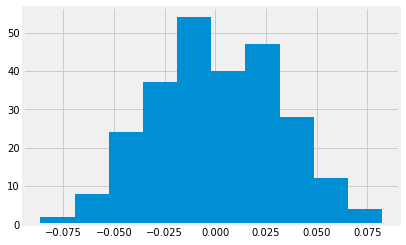

In [10]:
# histogram of residuals
Ytrain_pred = fit.predict(Xtrain)
res = Ytrain - Ytrain_pred
plt.hist(res)

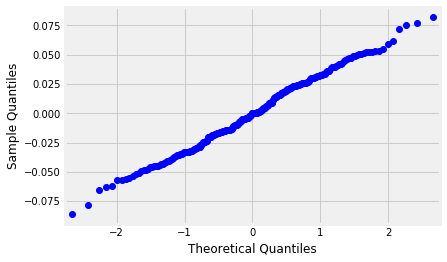

In [11]:
# Q-Q plot of residuals
sm.qqplot(res)
plt.show()

The above Q-Q plot and histogram don't appear to indicate that any violation of the assumption that the residuals are normall distributed. Let's look at a scatter of the residuals to see about homoscedasticity and no autocorrelation.

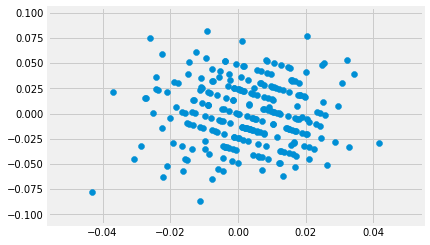

In [12]:
# residuals vs. fit
plt.scatter(Ytrain_pred, res)
plt.show()

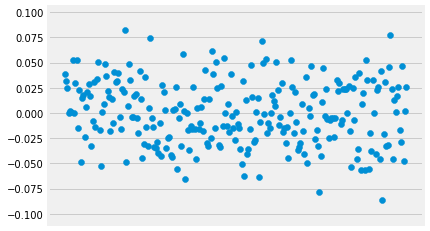

In [13]:
# residuals vs. observation
plt.scatter(dftrain.index, res)
plt.xticks([])
plt.show()

OK, the above looks quite satisfactory to me in meeting linear regression assumptions. Let's now take a look at performance on the test set.

In [14]:
Ytest_pred = fit.predict(Xtest)
SE = (Ytest - Ytest_pred) ** 2
ST = (Ytest - Ytest.mean()) ** 2
Rsq_test = 1 - (sum(SE)/sum(ST))
Rsq_test

-0.017248657464892014

OK, we can probably conclude now that the model is underfit or just does not include the adequate set of features. But let's perform some regularization and feature selection anyhow. Start with "Select K Best".

In [15]:
from sklearn import preprocessing, linear_model, pipeline, model_selection, feature_selection, metrics

In [16]:
select_pipe = pipeline.Pipeline(
    [("std", preprocessing.StandardScaler()),
    ("select",
      feature_selection.SelectKBest(
          score_func=feature_selection.f_regression, k=3)),
     ("ols", linear_model.LinearRegression())])
select_pipe.get_params()

{'memory': None,
 'ols': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
 'ols__copy_X': True,
 'ols__fit_intercept': True,
 'ols__n_jobs': 1,
 'ols__normalize': False,
 'select': SelectKBest(k=3, score_func=<function f_regression at 0x1c3052cd90>),
 'select__k': 3,
 'select__score_func': <function sklearn.feature_selection.univariate_selection.f_regression>,
 'std': StandardScaler(copy=True, with_mean=True, with_std=True),
 'std__copy': True,
 'std__with_mean': True,
 'std__with_std': True,
 'steps': [('std', StandardScaler(copy=True, with_mean=True, with_std=True)),
  ('select',
   SelectKBest(k=3, score_func=<function f_regression at 0x1c3052cd90>)),
  ('ols',
   LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))]}

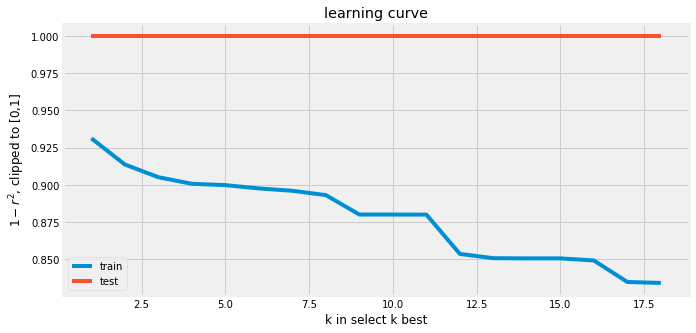

In [17]:
plt.figure(figsize=(10,5))
train_scores = []
test_scores = []
num_fs = range(1, len(Xtrain.columns), 1)
for i, num_f in enumerate(num_fs):
    select_pipe.set_params(select__k=num_f)
    fit = select_pipe.fit(Xtrain.drop('Ones', axis=1), Ytrain)
    train_scores.append(fit.score(Xtrain.drop('Ones', axis=1), Ytrain))
    test_scores.append(fit.score(Xtest.drop('Ones', axis=1), Ytest))

plt.plot(num_fs, 1 - np.array(train_scores), label="train")
plt.plot(num_fs, 1 - np.maximum(test_scores, 0), label="test")
plt.xlabel("k in select k best")
plt.ylabel("$1-r^2$, clipped to [0,1]")
plt.title("learning curve")
plt.legend()

In [18]:
select_pipe.set_params(select__k=3)
fit = select_pipe.fit(Xtrain.drop('Ones', axis=1),Ytrain)
features = select_pipe.named_steps['select']
features.get_support()

array([False,  True, False,  True, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False])

In [19]:
Xtrain.drop('Ones', axis=1).columns[features.get_support()]

Index(['MOV', 'SRS', 'DRtg'], dtype='object')

In [20]:
fit.score(Xtrain.drop('Ones', axis=1), Ytrain)

0.09488802662118911

In [21]:
fit.score(Xtest.drop('Ones', axis=1), Ytest)

-0.08542555289888543

This doesn't appear to help things? Let's try ridge.

In [22]:
ridge_pipe = pipeline.Pipeline([ 
     ("std", preprocessing.StandardScaler()),
     ("var", feature_selection.VarianceThreshold()), 
     ("ridge", linear_model.Ridge())
    ])

In [23]:
x = dfnotank.drop(['diffWP', 'Year', 'Ones'], axis=1)
y = dfnotank['diffWP']

In [29]:
# alphas look best when logspaced
alphas = np.logspace(.5, 5, num=50)
coefs = []
train_scores = []
test_scores = []
fits = []

# loop through each of the 50 alphas
for i, alpha in enumerate(alphas):
    # set the alpha for our pipeline
    ridge_pipe.set_params(ridge__alpha=alpha)
    # cross validate and store the results
    fit = ridge_pipe.fit(Xtrain.drop('Ones', axis=1), Ytrain)
    # use np.maximum(., 0) to make sure the scores don't go below zero (makes for ugly plots tbh)
    train_scores.append(fit.score(Xtrain.drop('Ones', axis=1), Ytrain))
    test_scores.append(fit.score(Xtest.drop('Ones', axis=1), Ytest))
    
    # fit again to grab coefficients
    # ridge_pipe.fit(Xtrain.drop('Ones', axis=1), Ytrain)
    fits.append(ridge_pipe.fit(Xtrain.drop('Ones', axis=1), Ytrain))
    coefs.append(ridge_pipe.named_steps["ridge"].coef_)

/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


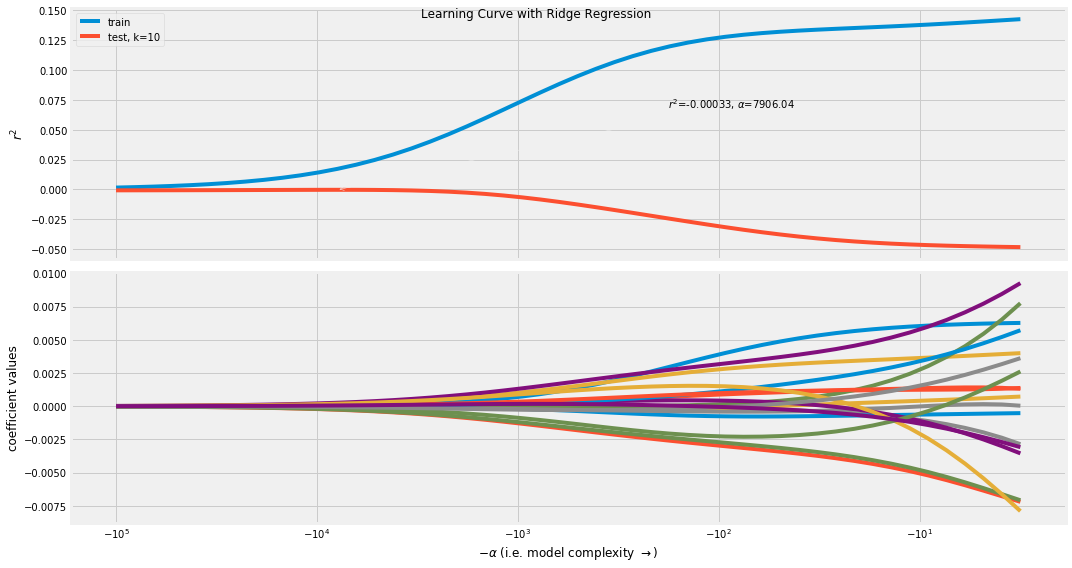

In [30]:
# set up the figure. I'll do the learning curve above and coefficient path below
fig, axes = plt.subplots(2, 1, figsize=(15, 8), sharex=True, tight_layout=True)
# list of arrays -> single array
coef_arr = np.squeeze(coefs, axis=1)
# grab the first axis
ax0 = axes.flat[0]
# plot train and test curves
ax0.plot(-alphas, train_scores, label="train")
ax0.plot(-alphas, test_scores, label="test, k=10")
# find the index of the best score
best_i = np.argmax(test_scores)
# annotate score
ann_xy = (-alphas[best_i], test_scores[best_i])
ann_text = f"$r^2$={test_scores[best_i]:.2}, $\\alpha$={alphas[best_i]:g}"
ax0.annotate(ann_text, xy=ann_xy, xytext=(.6,.6), textcoords='axes fraction',
            arrowprops=dict(arrowstyle="->"),
            )
ax0.set_ylabel("$r^2$")
ax0.legend()

# grab the second axis
ax1 = axes.flat[1]
ax1.plot(-alphas, coef_arr)
ax1.set_ylabel("coefficient values")
ax1.set_xlabel("$-\\alpha$ (i.e. model complexity $\\rightarrow$)")
fig.suptitle("Learning Curve with Ridge Regression")
plt.xscale("symlog")

In [31]:
best_fit = fits[best_i]
best_fit.score(Xholdout.drop('Ones', axis=1), Yholdout)

-0.01207752582011934

In [26]:
sorted(list(zip(Xtrain.columns, coefs[best_i])), key=lambda t: abs(t[1]), reverse=True)

[('MOV', -0.0002651671932488829),
 ('DRtg', 0.00026050619456087514),
 ('SRS', -0.0002492294319450956),
 ('DeFG%', 0.0001888730799508379),
 ('SOS', 0.00018261221740331455),
 ('DTOV%', -0.00014318753105017326),
 ('DRB%', -7.005404431202603e-05),
 ('Age', 6.461585142481043e-05),
 ('OFT/FGA', 6.308014510524078e-05),
 ('DFT/FGA', 5.595196057470016e-05),
 ('OeFG%', -5.306974367427954e-05),
 ('OTOV%', 4.993324749838321e-05),
 ('FTr', 4.603058639994483e-05),
 ('3PAr', -4.18607489796482e-05),
 ('ORB%', 4.014859349375427e-05),
 ('ORtg', -3.1219620386483234e-05),
 ('TS%', -2.4546829908474437e-05),
 ('Pace', -1.6936720858375106e-05)]

This particular data doesn't seem promising -- in training $R^2$ appears to be poor and in test, things get even worse. Any issues with collinearity don't appear to be resolved as well, as the largest coefficient values are not entirely independent. `MOV`, team margin of victory correlates with `SRS` (Basketball-Reference's  custom statistic for team strength accounting for schedule and margin of victory) and `DRtg` (a measure of points allowed by a team per 100 possessions).

I am going to move on and look at data from NBA.com for clutch performance.

In [55]:
import pickle

In [56]:
with open('bbref_team_all_02_18.pkl', 'wb') as picklefile:
    pickle.dump(df, picklefile)

In [57]:
with open('bbref_team_notank_02_18.pkl', 'wb') as picklefile2:
    pickle.dump(dfnotank, picklefile2)